In [ ]:
import torch.nn as nn
import torch

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257, # used by the BPE tokenizer
    "context_length" : 256,
    "emb_dim" : 768, # each input token is transformed in a 768-dimensional embedding
    "n_heads" : 12, # number of attention-heads in multi-head-attention mechanism
    "n_layers" : 12,
    "drop_rate" : 0.1, # dropout regularization
    "qvb_bias" : False # query-key-value bias
}

In [ ]:
# implementazione del layer di normalizzazione
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 # per evitare di dividere per zero
    self.scale = nn.Parameter(torch.ones(emb_dim)) # parametri aggiuntivi allenabili
    self.shift = nn.Parameter(torch.zeros(emb_dim)) # parametri aggiunti allenabili

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale * x + self.shift # operazioni elemento per elemento

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5*x*(1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) *
        (x+0.044715*torch.pow(x,3))
    ))

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
# mha module
class MultiHeadAttention(nn.Module):

  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):

    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # linear layer to combine head outputs

    self.dropout = nn.Dropout(dropout) # layer di dropout

    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    # [b, num_tokens, d_out]
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # [b, num_tokens, num_heads, head_dim]
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    # [b, num_heads, num_tokens, head_dim]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2) # Q
    attn_scores = queries @ keys.transpose(2, 3) # K^T

    # causal masking
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    # normalization
    attn_weights = torch.softmax(
      attn_scores / keys.shape[-1]**0.5, dim=-1
    )

    # droput regularization
    attn_weights = self.dropout(attn_weights)
    context_vec = (attn_weights @ values).transpose(1, 2)

    # output factorization: [b, num_tokens, num_heads*head_dim]]
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # Z

    # proiezione addizionale facoltativa
    context_vec = self.out_proj(context_vec)

    return context_vec

In [ ]:
# trasformer block
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"] # Use 'qkv_bias' from config
    )

    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x

    # attention module
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    # feed-forward network
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x) # linear layer --> GELU --> linear layer
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    return x

In [ ]:
class GPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
          *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(
        cfg['emb_dim'], cfg['vocab_size'], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_length = in_idx.shape

    # creazione token di input con poitional encoding
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_length, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds

    # dropout layer
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):

  for _ in range(max_new_tokens): # genera un massimo di max_new_tokens parole
    idx_cond = idx[:, -context_size:] # vengono considerati gli ultimi context_size elementi della serie generata
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :] # si considera l'ultimo vettore di logit nella sequenza di output per la generazione del prossimo token
    probas = torch.softmax(logits, dim = -1)
    idx_next = torch.argmax(probas, dim = -1, keepdim = True)
    idx = torch.cat((idx, idx_next), dim = 1)

  return idx

# 5\.1 Generate Text and Computing Loss

## 5.1.1 Generate Text

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

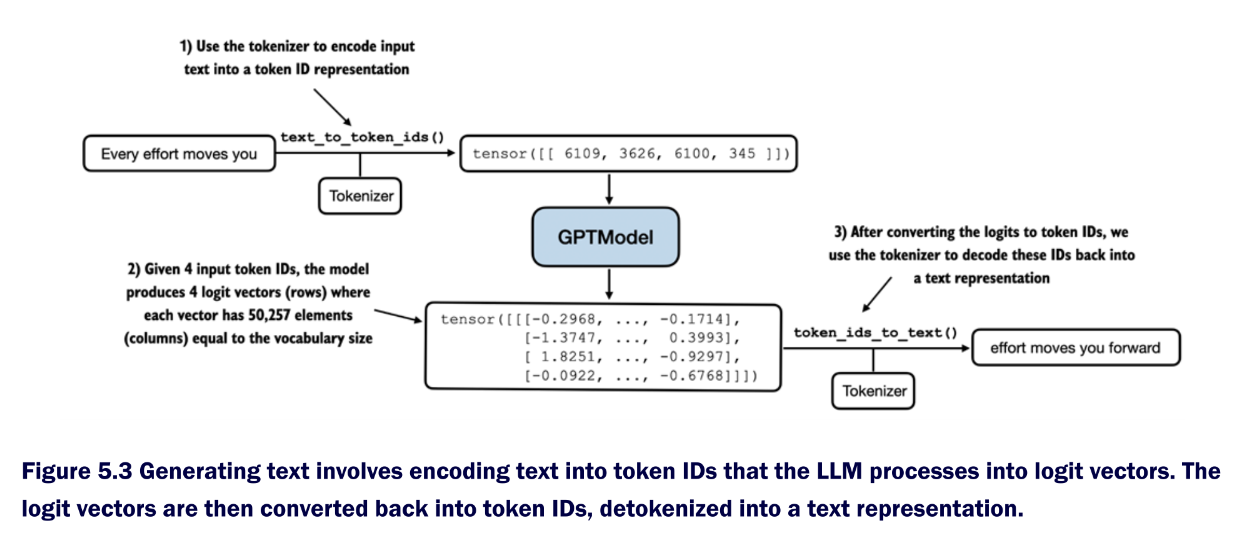

In [ ]:
# implementiamo delle funzioni che ci serviranno da qui in avanti
import tiktoken

# prende il testo e lo converte in vettori one-hot di dimensione pari a quella del dizionario considerato
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # added batch dimension
  return encoded_tensor

# fa il contrario della funzione di prima (token --> testo)
def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

Il testo generato e completamente casuale. Infatti dobbiamo ancora allenare il modello per avvicinarci ad aere un output sensato. Per iniziare la fase di training abbiamo per prima cosa bisogno di definire una *text loss metric*

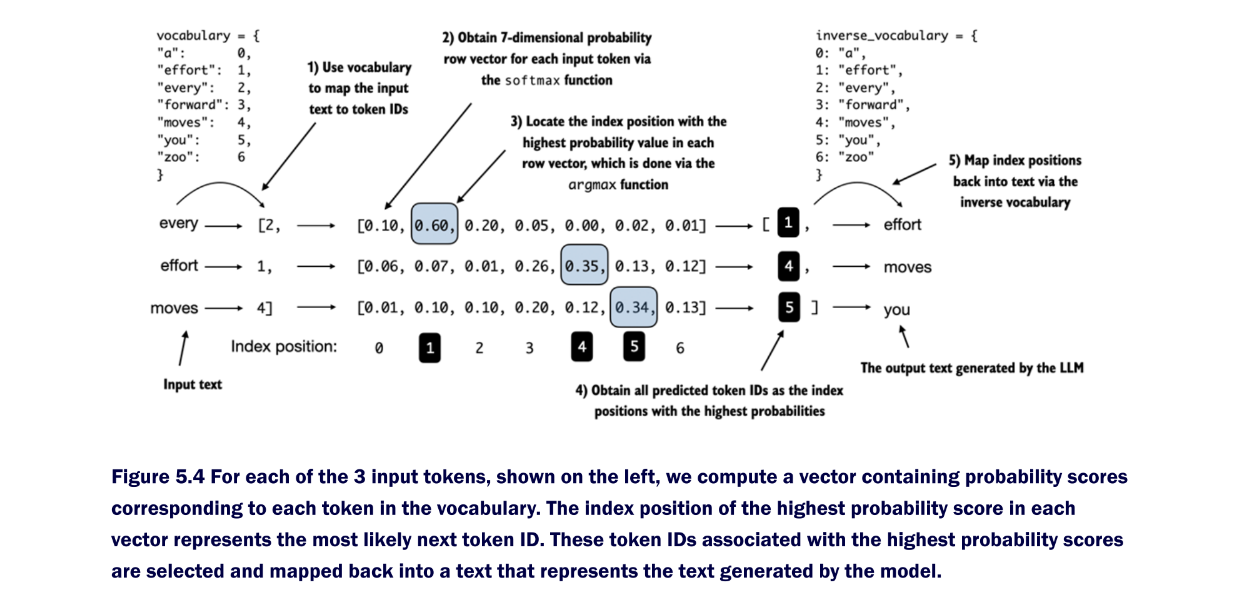

In [ ]:
start_context = 'Every effort moves you'
tokenizer = tiktoken.get_encoding("gpt2")

# utilizziamo il modello per generare dei nuovi token ids
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size=GPT_CONFIG_124M['context_length']
)

print('Output del modello: \n', token_ids)
print('\n')
print('Output text: \n', token_ids_to_text(token_ids, tokenizer))

inputs = torch.tensor([
    [16833, 3626, 6100], # every effort moves
    [40, 1107, 588] # I realy like
])

targets = torch.tensor([
    [3626, 6100, 345], # effort moves you
    [1107, 588, 11311] # really like chocolate
    ])

with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits, dim = -1)
print(probas.shape)

In [ ]:
token_ids = torch.argmax(probas, dim = -1, keepdim= True)
print('Predicted Token IDs: \n',  token_ids)

In [ ]:
print(f'Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}')
print(f'Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}')

## 5.1.2 Defining the loss function

In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]] # predicted probabilities of the target words, first batch
print("Text 1: \n", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]] # predicted probabilities of the target words, second batch
print("Text 2: \n", target_probas_2)

### 🎯 L'Obiettivo: Massimizzare la Probabilità Corretta

Durante l'addestramento, il compito del modello è molto specifico: **prevedere il token (parola o sotto-parola) successivo in una sequenza**.

Per farlo, il modello osserva i token precedenti e genera un punteggio (un *logit*) per ogni singola parola nel suo dizionario. Questi punteggi vengono poi trasformati in probabilità (da 0% a 100%) usando una funzione chiamata **softmax**.

Il nostro obiettivo è semplice: vogliamo che la **probabilità assegnata al token corretto** (quello che *realmente* segue nella sequenza) sia la più alta possibile, idealmente vicina a 1 (cioè 100%).

## 📉 Come Misuriamo l'Errore? La Funzione di Loss

Come facciamo a "insegnare" al modello a fare questo? Abbiamo bisogno di un modo per misurare il suo **errore**. Qui entra in gioco la **funzione di loss** (o funzione di costo).

Pensa alla loss come a una "penalità":
* Se il modello è **molto sicuro** della parola giusta (es. assegna 99% alla parola corretta), la penalità sarà **bassissima**.
* Se il modello è **molto incerto** o, peggio, predice la parola sbagliata (es. assegna 1% alla parola corretta), la penalità sarà **altissima**.

La funzione perfetta per questo lavoro si chiama **Cross-Entropy** (o entropia incrociata).

---

## 🧠 Spiegare la Cross-Entropy: Due "Opinioni" a Confronto

La cross-entropy misura la "distanza" o discrepanza tra due distribuzioni di probabilità. Nel nostro caso, stiamo confrontando due "opinioni" su quale dovrebbe essere la parola successiva:

1.  L'Opinione del Modello (chiamiamola $q$): È la distribuzione di probabilità che il modello ha generato dopo la softmax. È un lungo vettore con migliaia di piccole probabilità, una per ogni parola del dizionario (es: `gatto: 10%, cane: 5%, mangia: 60%, ...`).
2.  L'Opinione della Verità (chiamiamola $p$): È la distribuzione che rappresenta la risposta giusta. Questa distribuzione è "certa": assegna probabilità **1** (100%) alla parola corretta e **0** a tutte le altre. Questa è nota come rappresentazione **"one-hot"**. (es: `gatto: 0%, cane: 0%, mangia: 100%, ...`).

### La Magia della Semplificazione

La formula generale della cross-entropy è:
$$H(p, q) = - \sum_{i} p(i) \log(q(i))$$
Dove $i$ rappresenta ogni singola parola del dizionario.

Ora, applichiamola al nostro caso. La distribuzione vera $p(i)$ è quasi tutta zero! È $p(i)=1$ solo per la parola corretta e $p(i)=0$ per tutte le altre.

Questo significa che tutti i termini della sommatoria si annullano (perché $0 \cdot \log(\dots) = 0$), **tranne uno**: quello della parola corretta!

Per quella singola parola, $p(i) = 1$, quindi la formula si semplifica magicamente in:

$$\text{Loss} = -1 \cdot \log(q(\text{parola_corretta}))$$

Dove $q(\text{parola_corretta})$ è la probabilità che il modello ha assegnato alla risposta giusta.

L'obiettivo dell'addestramento (minimizzare la loss) costringe il modello a spingere la probabilità della parola corretta il più vicino possibile a 1.

## 🌍 Dal Singolo Token all'Intero Batch

Naturalmente, non addestriamo il modello su una sola parola alla volta. Lo facciamo su interi "batch" (lotti) di sequenze di testo.

Il processo è questo:
1.  Il modello riceve un blocco di sequenze (es: 32 frasi diverse).
2.  Per **ogni singolo token** in quel blocco (escluso l'ultimo di ogni frase), il modello tenta di predire il token che viene subito dopo.
3.  Calcoliamo la nostra loss (il $-\log(q)$) per **ognuna di queste singole previsioni**.
4.  La **Loss Totale** del batch è semplicemente la **media** di tutte queste singole loss.

Minimizzando questa media, il modello impara a diventare bravo a prevedere *qualsiasi* parola in *qualsiasi* contesto gli venga presentato.

In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)
avg_log_probas = torch.mean(log_probas)
cross_entropy_loss = -avg_log_probas
print(cross_entropy_loss)

In [ ]:
print(logits.shape) # model output
print(targets.shape) # target values

L'implementazione della funzione di loss che abbiamo proposto sopra funziona allo stesso modo di quella implementata all'interno di PyTorch.

In [ ]:
# usando l'implementazione PyTorch, dobbiamo srotolare l'output del modello considerando tutti i batch in una volta sola
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print('Flattened targets:', targets_flat.shape)

In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

### 📈 Dalla Loss all'Interpretazione: Cos'è la Perplexity?

Abbiamo stabilito che il nostro obiettivo è **minimizzare la cross-entropy loss**. Questa loss (il nostro $-\log(q)$) è un numero che vogliamo spingere verso lo 0.

Tuttavia, la cross-entropy non è molto "intuitiva". Se ti dicessi che il mio modello ha una cross-entropy media di 5.2, è buono? O è 2.1? È difficile da giudicare senza un contesto.

Qui entra in gioco la **Perplexity (PPL)**.

> **Definizione Chiave:** La Perplexity è semplicemente l'**esponenziale** della cross-entropy loss.
>
> $$\text{Perplexity} = e^{\text{Cross-Entropy Loss}}$$

È un modo diverso di esprimere *esattamente la stessa informazione*, ma in una scala molto più facile da interpretare per noi umani.

## 🤯 L'Intuizione: Il "Numero di Scelte"

La Perplexity risponde a una domanda molto intuitiva:

**"Quanto è 'perplesso' o 'confuso' il modello nel predire il prossimo token?"**

Immagina un modello che, in un certo momento, non ha idea di quale sia la parola successiva e si trova di fronte a **$K$** possibili scelte ugualmente probabili.

Ad esempio, è *perfettamente indeciso* tra $K=10$ parole (es. "gatto", "cane", "topo", "casa", "albero", ecc.).

1.  **Quale probabilità assegna alla parola corretta?**
    Se è indeciso in modo uniforme tra $K=10$ scelte, assegnerà a ciascuna una probabilità identica: $q = \frac{1}{K} = \frac{1}{10} = 0.1$.

2.  **Calcoliamo la Cross-Entropy Loss (L):**
    Come abbiamo visto, la loss è $L = - \log(q(\text{parola\_corretta}))$.
    * $L = - \log(\frac{1}{K})$
    * Usando le proprietà dei logaritmi ($\log(\frac{1}{x}) = - \log(x)$), la formula diventa:
    * $L = - (-\log(K)) = \log(K)$
    * Quindi, per $K=10$ scelte, la loss è $L = \log(10) \approx 2.3$.

3.  **Calcoliamo la Perplexity (PPL):**
    La perplexity è l'esponenziale della loss: $\text{PPL} = e^L$.
    * $\text{PPL} = e^{\log(K)}$
    * Poiché l'esponenziale ($e^x$) e il logaritmo naturale ($\log$ o $\ln$) sono funzioni inverse, si annullano a vicenda.
    * $\text{PPL} = K$

**Ecco la magia:** In questo scenario ideale in cui il modello è uniformemente indeciso tra $K$ scelte, la Perplexity è **esattamente $K$**.

Se il modello è confuso tra 10 parole, PPL = 10.
Se il modello è confuso tra 100 parole, PPL = 100.
L'obiettivo è avere una perplexity la più bassa possibile, vicina a 1.

## 🔗 La Matematica: Il Legame Inseparabile

Vediamo come la Perplexity (PPL) deriva dalla cross-entropy media (che chiamiamo $L$) su una sequenza di $N$ token.

1.  **La nostra Loss Media (Cross-Entropy):**
    Come abbiamo visto, questa è la media di tutte le singole "penalità" (il logaritmo negativo della probabilità corretta) su $N$ token.
    $$L = - \frac{1}{N} \sum_{i=1}^{N} \log(q_i(\text{parola\_corretta}_i))$$

2.  **La Definizione di Perplexity:**
    Applichiamo semplicemente l'esponenziale ($e^x$) a quella loss media.
    $$\text{PPL} = e^{L} = e^{- \frac{1}{N} \sum_{i=1}^{N} \log(q_i(\text{parola\_corretta}_i))}$$

### Una Semplificazione Elegante (Opzionale)

Usando le proprietà dei logaritmi e degli esponenziali, questa formula può essere riscritta in un modo che ne rivela il vero significato. La PPL è la **media geometrica inversa** delle probabilità corrette.

$$\text{PPL} = \sqrt[N]{\frac{1}{q_1 \cdot q_2 \cdot \dots \cdot q_N}}$$

* $q_1, q_2, \dots$ sono le probabilità che il modello ha assegnato alle parole giuste, una dopo l'altra.
* Se il modello assegna sempre probabilità alte (vicine a 1), il denominatore è grande (vicino a 1), e la PPL è bassa (vicina a 1).
* Se anche solo *una* probabilità è molto bassa (es. $q_{10} = 0.001$), "rovina" la media e fa schizzare la PPL verso l'alto. Questo è positivo: penalizza molto i modelli che fanno errori grossolani.

## 🤝 Loss vs. Metrica: Due Facce della Stessa Medaglia

È fondamentale capire questa distinzione:

* **Cross-Entropy (Loss):** È la funzione che il modello **ottimizza** durante l'addestramento. È più "comoda" per il calcolo matematico dei gradienti (la *backpropagation*) perché è una somma.
* **Perplexity (Metrica):** È la metrica che gli **umani usano per valutare** e confrontare i modelli. È più facile da interpretare perché ci dà un "numero effettivo di scelte".

**Minimizzare la cross-entropy è matematicamente identico a minimizzare la perplexity.**

Poiché la funzione $e^x$ è *monotona crescente* (se $a < b$, allora $e^a < e^b$), qualsiasi miglioramento che riduce la cross-entropy ridurrà automaticamente anche la perplexity. Stanno scalando la stessa montagna, usando solo scale di misura diverse.

In [ ]:
print(torch.exp(loss))

Quindi in questo caso il modello e in media indceiso riguardo a 55000 token nella predizione del prossimo token. Questo e un risultato pessimo se si considera la dimensione del dizionario considerato (circa 57000 parole).

## 5.1.3 Calculating the training and validation set losses

Il testo che utilizziamo puo essere trovato al seguente link: https://en.wikisource.org/wiki/The_Verdict.

In [ ]:
file_path = "text.txt"
with open(file_path, "r", encoding="utf-8") as file:
  text_data = file.read()

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

In [ ]:
# suddivisione dei dati in insieme di allenamento e validazione
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [ ]:
# dataset
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt) # using BPE

    # crea le coppie input-input secondo una finestra mobile di larghezza max_length
    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+1+max_length]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

In [ ]:
from torch.utils.data import DataLoader

# dataloader
def create_dataloader_v1(txt, batch_size=4, max_length = 256,
                         stride = 128, shuffle = True, drop_last = True,
                         num_workers = 0):
  # shuffle: if the elements in each batch should be shuffled or not
  # stride: number of positions shift across batches (sliding window approach)
  # max_length: numebr of tokens in each batch
  # batch_size: number of input-output pairs in each batch
  tokenizer = tiktoken.get_encoding("gpt2") # BPE
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last = drop_last, # drops last batch if smaller than fixed batch_size
      num_workers = num_workers # CPU Number used during training
  )
  return dataloader

torch.manual_seed(123)

# creazione dei dataloader
train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last = True,
    shuffle = True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last = True,
    shuffle = True,
    num_workers=0
)

In [ ]:
print("Train Loader: \n")
for x,y in train_loader:
  print(x.shape, y.shape)

print("\nValidation Loader: ")
for x,y in val_loader:
  print(x.shape, y.shape)

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0,1), target_batch.flatten()
  )
  return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0
  if len(data_loader) == 0:
    return float('nan')
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  # calculate loss
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches # average loss over all batches

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print("Training Loss: ", train_loss)
print("Validation Loss: ", val_loss)

In [ ]:
print("Training perplexity: ", torch.exp(torch.tensor(train_loss)))
print("Validation perplexity: ", torch.exp(torch.tensor(val_loss)))

# 5\.2 Training an LLM

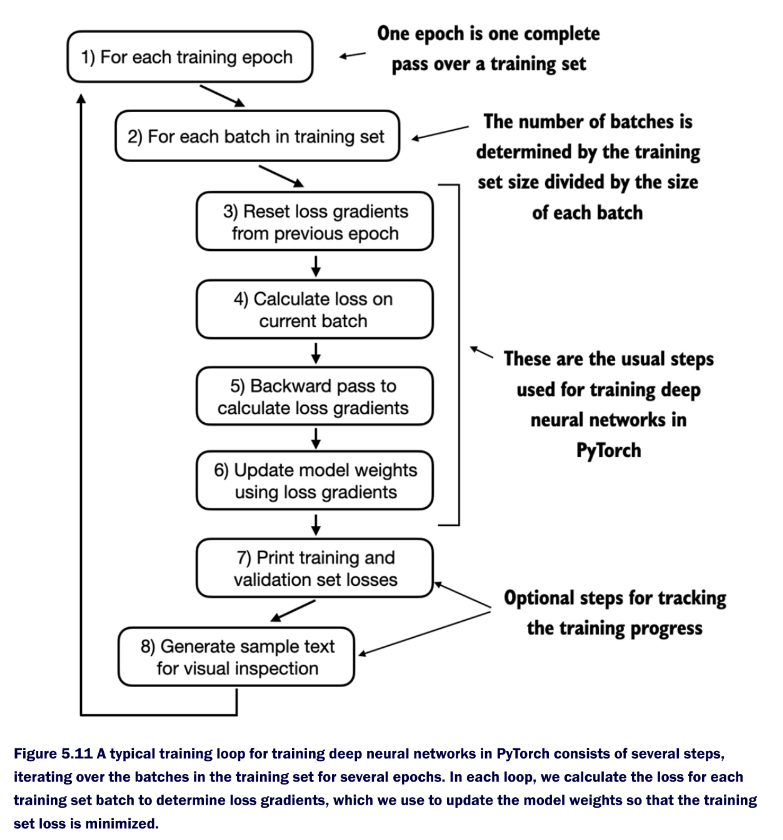

In [ ]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer): # Added eval_iter parameter
  train_losses, val_losses, track_tokens_seen = [],[],[]
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      loss.backward() # calcola il gradiente della loss in base al grafo computazione del modello
      optimizer.step() # aggiornamento dei parametri (step-wise method)
      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0: # step di valutazione opzionale
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter # Passing eval_iter to evaluate_model
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d}):"
        f"train loss {train_loss:3f}, "
        f"Val loss {val_loss:3f}")

    generate_and_print_sample( # stampa un testo di prova dopo ogni epoca
        model, tokenizer, device, start_context
    )

  return train_losses, val_losses, track_tokens_seen # Moved return outside the loop

# calcola la loss del modello sul train and evalution set
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval() # disabilita il dropout
  with torch.no_grad(): # disabilita il calcolo del gradiente
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches = eval_iter
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches = eval_iter
    )
  model.train()
  return train_loss, val_loss

# generate text sample from a start_context token
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0] # Corrected accessing shape
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(
        model = model, idx = encoded,
        max_new_tokens = 50, context_size = context_size
    )
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", ""))
  model.train()

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 4e-4, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=10, eval_freq=5, eval_iter = 5, # Removed eval_iter from here
    start_context = "Every effort moves you", tokenizer = tokenizer
)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize = (5,3))
  ax1.plot(epochs_seen, train_losses, label = 'Training Loss')
  ax1.plot(
      epochs_seen, val_losses, linestyle = '-.', label = 'Validation Loss'
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc = 'upper right')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha = 0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5.2.1 Text Generation Strategies

In [ ]:
model.to("cpu")
model.eval()

In [ ]:
# output del modello dopo questa prima fase di training
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)
print('output text: \n', token_ids_to_text(token_ids, tokenizer))

Per il momento il token che viene generato corrisponde al token a cui viene associata una maggiore probabilita secondo l'output di logit del modello. Questa tecnica prende il nome di greedy decoding. Per aggiungere varieta al testo generato e possibile implementare il temperature scaling. In pratica prendiamo i valori del vettore logit e li dividiamo per una costante sceta da noi, che prende il nome di `temperature`. Successivamente applichiamo la softmax al vettore risultato.

Settare il parametra `temperature`:
1. maggiore di 1, permette di rendere piu uniforme la distribuzione, aumentando la varieta dei token generati
2. minore di 1, permette di 'affilare' la distribuzione ottenuta, intorno ai suoi punti di massimo, rendendola piu certa.

In [ ]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits/temperature
  return torch.softmax(scaled_logits, dim = 0)

In [ ]:
# output ipotetico del modello
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79] # Corrected tensor values
)
# dummy vocab
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

# temperature scaling
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width  = 0.15
fig, ax = plt.subplots(figsize = (5,3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x+i*bar_width, scaled_probas[i],
                 bar_width, label = f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x + bar_width) # Adjusted xticks position
ax.set_xticklabels(vocab.keys(), rotation = 90)
ax.legend()
plt.tight_layout()
plt.show()

A questo punto e possibile utilizzare queste distribuzioni di output modificate, tramite un'apposita funzione di pytorch `torch.multinomial`

In [ ]:
def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i, freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")

In [ ]:
for i,j in zip(scaled_probas, temperatures):
  print("Temperatura: ", j)
  print_sampled_tokens(i)
  print('\n')

In [ ]:
def word_count(temperature, target_word_idx, probas, rounds):
  probas = softmax_with_temperature(probas, temperature)
  sample = torch.tensor([torch.multinomial(probas, num_samples=1).item() for i in range(rounds)])
  counts = torch.bincount(sample)
  return counts[target_word_idx]

In [ ]:
# pizza token count

# no temperature scaling
print(word_count(temperature=1, target_word_idx=6, probas = next_token_logits, rounds = 1000))

# high temperature scaling, all tokens become more likely
print(word_count(temperature=5, target_word_idx=6, probas = next_token_logits, rounds = 1000))

## 5.2.2 Top K-sampling

Se la `temperature` viene settata troppo alta, allora si rischia di ottenere un modello troppo creativo, i cui token generati non formano frasi di senso compiuto. Per risolvere questo problema si introduce il **top-K sampling**. Restringiamo il campo dei token estraibili durante la fase di generazione ai K piu probabili secondo la distribuzione output del modello.

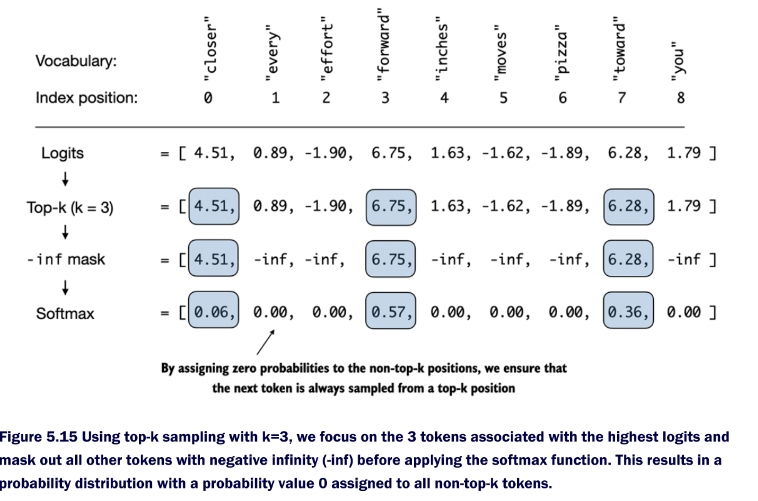

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

In [ ]:
new_logits = torch.where(
  condition=next_token_logits < top_logits[-1], # less than the K-smallest logit
  input=torch.tensor(float('-inf')), # assign this value to the logits that satsfy the condition
  other=next_token_logits # retains original logits for all the other positions
)

print(new_logits)

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

In questo modo abbiamo ottenuto una distribuzione di probabilita definita sui K token piu probabilie secondo la distribuzione di output.

## 5.2.3 Implementazione di una funzione di generazione del testo migliorata

In [ ]:
def generate(model, idx, max_new_tokens, context_size,
             temperature = 1.0, top_K = None, eos_id = None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:] # context window
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:] # select the last logits vector, used for next token generation

    # top-K sampling
    if top_K is not None:
        # Get the top K logits and their indices
        top_logits, _ = torch.topk(logits, top_K)
        # Get the smallest value among the top K logits
        min_top_logit = top_logits[:, -1].unsqueeze(1)
        # Set logits below the K-th largest to -inf
        logits = torch.where(
            condition=logits < min_top_logit,
            input=torch.tensor(float('-inf')).to(logits.device), # Ensure -inf is on the same device
            other=logits
        )

    # temperature scaling
    if temperature > 0.0:
      probs = torch.softmax(logits / temperature, dim = -1)
      pred = torch.multinomial(probs, 1)
    else:
      pred = torch.argmax(logits, dim = -1, keepdim=True)

    if eos_id is not None and pred == eos_id:
      break

    idx = torch.cat((idx, pred), dim = 1)
  return idx

In [ ]:
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

token_ids = generate(
  model=model,
  idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), # Move input tensor to the same device as the model
  max_new_tokens=15,
  context_size=GPT_CONFIG_124M["context_length"],
  top_K=25,
  temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

# 5\.3 Loading and Saving Model Weights in Pytorch

La fase di training del modello richiede molta potenza di calcolo. Genera dei costi ingenti in applicazioni reali, di conseguenza e necessario salvare il risultato dell'allenamento una ovlta concluso. Nello specifico, dobbiamo salvare i parametri del modello ad allenamento concluso.

Questo ci permettera anche di riutirizzare gli stessi parametri su un nuovo modello con la stessa struttura, ottenendo la stessa performance su modelli diversi.

In [ ]:
# si crea un dizionario che mappa ogni layer del modello ai suoi parametri e lo si salva
torch.save(model.state_dict(), "model.pth")

In [ ]:
# caricare i parametri da un file
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

Alcuni `optimizer` in PyTorch salvano dei parametri durante l'allenamento. E sempre utile, per sicurezza, creare dei checkpoint urante l'allenamento per esere sicuri di non perdersi niente.

In [ ]:
# salvare i parametri di allenamento
torch.save({
"model_state_dict": model.state_dict(), # salvare i parametri del modello
"optimizer_state_dict": optimizer.state_dict(), # salvare i parametri dell'optimizer
},
"model_and_optimizer.pth"
)

In [ ]:
# riutilizzare i parametri di allenamento salvati
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

I parametri originali di GPT2 possono essere trovati su tensorFlow.

In [ ]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

In [ ]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
  left.data = torch.tensor(right) # Directly update the parameter's data

In [ ]:
import numpy as np
def load_weights_into_gpt(gpt, params):
  device = gpt.pos_emb.weight.device # Get the device of the model parameters
  gpt.pos_emb.weight.data = torch.tensor(params['wpe'], dtype=gpt.pos_emb.weight.dtype, device=device) #A
  # Explicitly convert and assign wte to embedding and output head
  wte_tensor = torch.tensor(params['wte'], dtype=gpt.tok_emb.weight.dtype, device=device)
  gpt.tok_emb.weight.data = wte_tensor
  gpt.out_head.weight.data = wte_tensor #D

  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
    #B
    #C
    (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight.data = torch.tensor(q_w.T, dtype=gpt.trf_blocks[b].att.W_query.weight.dtype, device=device)
    gpt.trf_blocks[b].att.W_key.weight.data = torch.tensor(k_w.T, dtype=gpt.trf_blocks[b].att.W_key.weight.dtype, device=device)
    gpt.trf_blocks[b].att.W_value.weight.data = torch.tensor(v_w.T, dtype=gpt.trf_blocks[b].att.W_value.weight.dtype, device=device)

    if gpt.trf_blocks[b].att.W_query.bias is not None: # Check if bias exists
      q_b, k_b, v_b = np.split(
      (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
      gpt.trf_blocks[b].att.W_query.bias.data = torch.tensor(q_b, dtype=gpt.trf_blocks[b].att.W_query.bias.dtype, device=device)
      gpt.trf_blocks[b].att.W_key.bias.data = torch.tensor(k_b, dtype=gpt.trf_blocks[b].att.W_key.bias.dtype, device=device)
      gpt.trf_blocks[b].att.W_value.bias.data = torch.tensor(v_b, dtype=gpt.trf_blocks[b].att.W_value.bias.dtype, device=device)

    gpt.trf_blocks[b].att.out_proj.weight.data = torch.tensor(
    params["blocks"][b]["attn"]["c_proj"]["w"].T, dtype=gpt.trf_blocks[b].att.out_proj.weight.dtype, device=device)
    if gpt.trf_blocks[b].att.out_proj.bias is not None: # Check if bias exists
      gpt.trf_blocks[b].att.out_proj.bias.data = torch.tensor(
      params["blocks"][b]["attn"]["c_proj"]["b"], dtype=gpt.trf_blocks[b].att.out_proj.bias.dtype, device=device)

    gpt.trf_blocks[b].ff.layers[0].weight.data = torch.tensor(
                                                  params["blocks"][b]["mlp"]["c_fc"]["w"].T, dtype=gpt.trf_blocks[b].ff.layers[0].weight.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[0].bias.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_fc"]["b"], dtype=gpt.trf_blocks[b].ff.layers[0].bias.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[2].weight.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_proj"]["w"].T, dtype=gpt.trf_blocks[b].ff.layers[2].weight.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[2].bias.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_proj"]["b"], dtype=gpt.trf_blocks[b].ff.layers[2].bias.dtype, device=device)

    gpt.trf_blocks[b].norm1.scale.data = torch.tensor(
    params["blocks"][b]["ln_1"]["g"], dtype=gpt.trf_blocks[b].norm1.scale.dtype, device=device)
    gpt.trf_blocks[b].norm1.shift.data = torch.tensor(
    params["blocks"][b]["ln_1"]["b"], dtype=gpt.trf_blocks[b].norm1.shift.dtype, device=device)
    gpt.trf_blocks[b].norm2.scale.data = torch.tensor(
    params["blocks"][b]["ln_2"]["g"], dtype=gpt.trf_blocks[b].norm2.scale.dtype, device=device)
    gpt.trf_blocks[b].norm2.shift.data = torch.tensor(
    params["blocks"][b]["ln_2"]["b"], dtype=gpt.trf_blocks[b].norm2.shift.dtype, device=device)

  gpt.final_norm.scale.data = torch.tensor(params["g"], dtype=gpt.final_norm.scale.dtype, device=device)
  gpt.final_norm.shift.data = torch.tensor(params["b"], dtype=gpt.final_norm.shift.dtype, device=device)

In [ ]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [ ]:
# model parameters
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

In [ ]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

In [ ]:
token_ids = generate(
  model=gpt,
  idx=text_to_token_ids("Every effort moves you", tokenizer),
  max_new_tokens=25,
  context_size=NEW_CONFIG["context_length"],
  top_K=30,
  temperature=1
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))